Install Tensorflow and required libraries

In [4]:
%%capture
!pip install tensorflow

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from PIL import Image
import matplotlib.pyplot as plt
import os
import zipfile
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#### Data Interpretation

Read the file from Google Drive, unzip and create folders

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
!ls /content/gdrive/MyDrive/colab

images.zip  monreader0507.ipynb  monreader59-main.ipynb


In [8]:
%%capture
!unzip gdrive/MyDrive/colab/images.zip

In [9]:
# Shows the sub-folders for training
!ls images/training

flip  notflip


Rename the sub-folders so that they will be sequential
a_notflip  0
b_flip 1

In [10]:
! mv images/training/notflip images/training/a_notflip

In [11]:
! mv images/training/flip images/training/b_flip

In [12]:
!ls images/training

a_notflip  b_flip


In [13]:
xdir=os.listdir("images/training")
xdir

['a_notflip', 'b_flip']

Check the number of images for each class of Training set

In [14]:
print("Number of images in training for",os.listdir('images/training')[0] ,"class",len(os.listdir('images/training/'+os.listdir('images/training')[0])))
print("Number of images in training for",os.listdir('images/training')[1] ,"class",len(os.listdir('images/training/'+os.listdir('images/training')[1])))

Number of images in training for a_notflip class 1230
Number of images in training for b_flip class 1162


Display a few images from the training folder

Displaying images from Flip folder
 
images/training/b_flip/0039_000000023.jpg 

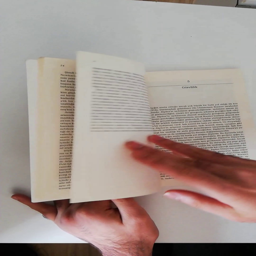

images/training/b_flip/0015_000000014.jpg 

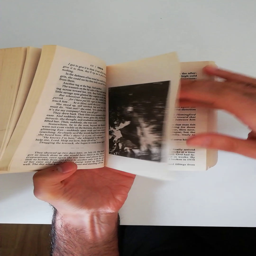

images/training/b_flip/0056_000000024.jpg 

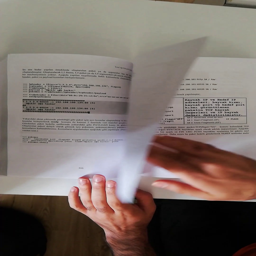

images/training/b_flip/0036_000000018.jpg 

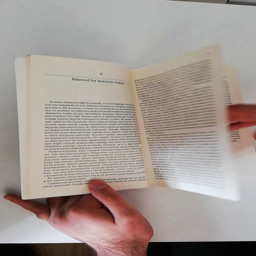

images/training/b_flip/0006_000000023.jpg 

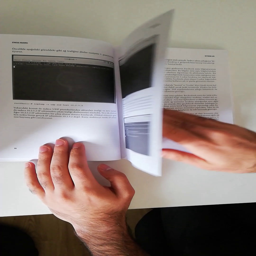

Displaying images from Flip folder
 


In [15]:
img_dir="images/training/b_flip"
i = 0
source=os.listdir(img_dir)
print("Displaying images from Flip folder")
print(" ")
while i < 5:
        fname=os.path.join(img_dir,source[i])
        im=Image.open(fname)
        print(fname, end=' ')
        display(im.resize((256,256)))
        i=i+1
print("Displaying images from Flip folder")
print(" ")

Displaying images from Not Flip folder
 
images/training/a_notflip/0048_000000004.jpg 

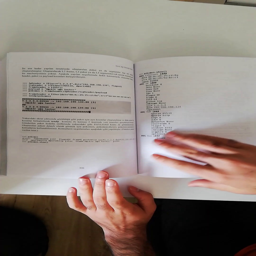

images/training/a_notflip/0039_000000023.jpg 

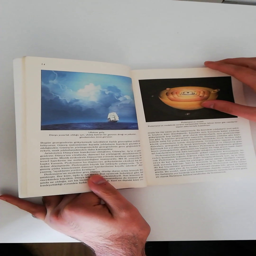

images/training/a_notflip/0054_000000006.jpg 

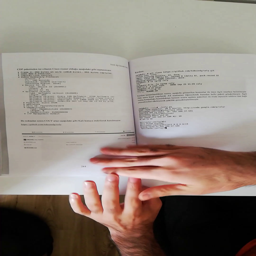

images/training/a_notflip/0015_000000014.jpg 

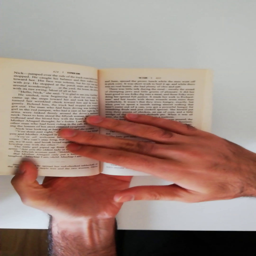

images/training/a_notflip/0001_000000027.jpg 

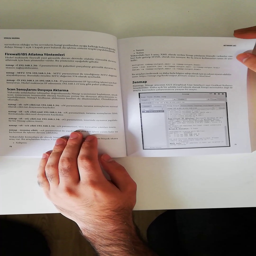

Displaying images from Not Flip folder


In [16]:
img_dir="images/training/a_notflip"
i = 0
source=os.listdir(img_dir)
print("Displaying images from Not Flip folder")
print(" ")
while i < 5:
        fname=os.path.join(img_dir,source[i])
        im=Image.open(fname)
        print(fname, end=' ')
        display(im.resize((256,256)))
        i=i+1
print("Displaying images from Not Flip folder")

Read the images from the training folder. The images are split into training and validaiton set

In [17]:
! pip install keras.preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 916.9 kB/s eta 0:00:00


In [18]:
from keras.preprocessing import image_dataset_from_directory
path ="images/training"
path

'images/training'

#### Data Pre-processing

In [2]:
img_height=128
img_width=128

In [19]:
train_ds=image_dataset_from_directory(path, labels="inferred", label_mode='binary',validation_split=0.2,subset='training',shuffle=True, seed=42,image_size=(img_height,img_width),batch_size=2000)

Found 2392 files belonging to 2 classes.
Using 1914 files for training.


In [20]:
val_ds=image_dataset_from_directory(path,labels="inferred",label_mode='binary',validation_split=0.2,shuffle=True,subset='validation',seed=42,image_size=(img_height,img_width),batch_size=500)

Found 2392 files belonging to 2 classes.
Using 478 files for validation.


Display the Class Names of the Training data.

In [21]:
class_names=train_ds.class_names
class_names


['a_notflip', 'b_flip']

In [22]:
from tensorflow import image
# # train_ds=keras.preprocessing.image.apply_brightness_shift(train_ds,0.1)
# train_ds = train_ds.map(lambda x, y: (tf.image.adjust_brightness(x, delta= -0.4), y))
# train_ds = train_ds.map(lambda x, y: (tf.image.adjust_contrast(x, 0.9), y))

Display few images and labels from the train dataset, we display images from batch 2

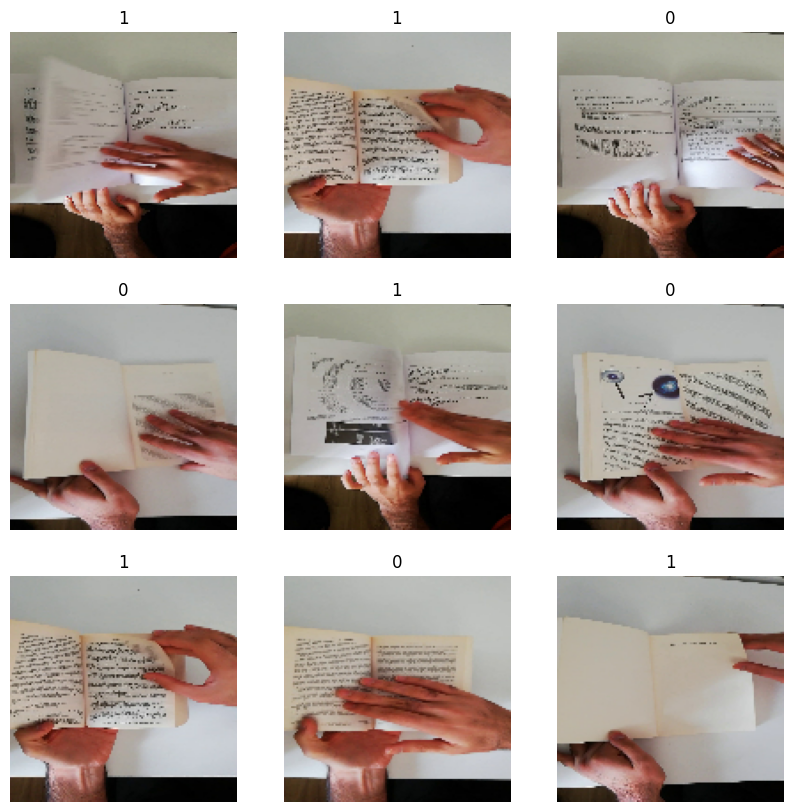

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(class_names[int(labels[i])] + " " + str(int(labels[i])))
    plt.title(str(int(labels[i])))
    # print(int(labels[i]))
    plt.axis("off")




#### Model Development

In [24]:
from keras.layers import Resizing
from keras.layers import Rescaling
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.losses import SparseCategoricalCrossentropy

In [30]:
model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height,img_width, 3)),
      tf.keras.layers.Conv2D(64,(5,5),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128,activation='relu'),
      layers.Dense(1,activation="sigmoid")
])

Compile using loss function Binary Crossentropy and get the metrics

In [31]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),
]

model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics= metrics)

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 124, 124, 64)      4864      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 62, 62, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                 

Define the callback function

In [33]:
class myCallback(tf.keras.callbacks.Callback):
        # Check after epoch end
        def on_epoch_end(self,epoch,logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.98:
                print("\nStopped as desried Training Accuracy reached")
                # Stop when accuracy is reached
                self.model.stop_training = True
callback =myCallback()



### Model Training

In [35]:
ep = 40
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = ep,
    callbacks=callback,
    batch_size = 32
    )

Epoch 1/40
1/1 [==============================] - 16s 16s/step - loss: 0.6388 - accuracy: 0.6379 - precision: 0.9107 - recall: 0.2763 - auc: 0.7646 - prc: 0.7765 - val_loss: 0.6001 - val_accuracy: 0.6757 - val_precision: 0.8818 - val_recall: 0.4059 - val_auc: 0.7980 - val_prc: 0.8265
Epoch 2/40
1/1 [==============================] - 16s 16s/step - loss: 0.5967 - accuracy: 0.6782 - precision: 0.8287 - recall: 0.4193 - auc: 0.7717 - prc: 0.7727 - val_loss: 0.6057 - val_accuracy: 0.7406 - val_precision: 0.7309 - val_recall: 0.7615 - val_auc: 0.7858 - val_prc: 0.8166
Epoch 3/40
1/1 [==============================] - 16s 16s/step - loss: 0.5904 - accuracy: 0.7147 - precision: 0.7111 - recall: 0.6880 - auc: 0.7702 - prc: 0.7723 - val_loss: 0.6193 - val_accuracy: 0.5962 - val_precision: 0.5632 - val_recall: 0.8577 - val_auc: 0.7835 - val_prc: 0.8144
Epoch 4/40
1/1 [==============================] - 16s 16s/step - loss: 0.6195 - accuracy: 0.6463 - precision: 0.5986 - recall: 0.8093 - auc: 0.74

Display the metrics for the model

In [36]:
history.history


{'loss': [0.6387938857078552,
  0.5966988205909729,
  0.5903938412666321,
  0.6195096373558044,
  0.6094573140144348,
  0.5916130542755127,
  0.5871294140815735,
  0.5934818983078003,
  0.5776997208595276,
  0.559589684009552,
  0.5597239136695862,
  0.5429444909095764,
  0.5475170612335205,
  0.5262370109558105,
  0.5307531356811523,
  0.5368420481681824,
  0.5012260675430298,
  0.4819093346595764,
  0.48505568504333496,
  0.47610560059547424,
  0.470266193151474,
  0.46168071031570435,
  0.4418987035751343,
  0.42907649278640747,
  0.42852145433425903,
  0.4045052230358124,
  0.4307684898376465,
  0.40242812037467957,
  0.396982878446579,
  0.36596381664276123,
  0.3664764165878296,
  0.36103540658950806,
  0.3538728356361389,
  0.3357972204685211,
  0.33172887563705444,
  0.3304804265499115,
  0.3470431864261627,
  0.3450961410999298,
  0.31367427110671997,
  0.3205234706401825],
 'accuracy': [0.6379310488700867,
  0.6781609058380127,
  0.7147335410118103,
  0.6462904810905457,
  0.

Calculate the F1 score for each epoch using the precision and recall for each epoch

In [37]:
i=0
j=0
f1=[]
for i,j in zip(history.history['precision'],history.history['recall']):
  if i != 0 or j != 0:
      f=2 * (i * j) / (i + j)
  else:
      f=0.0
  f1.append(f)
history.history['f1']=f1

l=0
m=0
vf1=[]
for l,m in zip(history.history['val_precision'],history.history['val_recall']):
    if l != 0 or m != 0:
        vf=2 * (l * m) / (l + m)
    else:
        vf=0.0
    vf1.append(vf)
history.history['val_f1']=vf1

In [38]:
history.history['f1']

[0.4239401353120132,
 0.5568345356368233,
 0.6993391897372339,
 0.6881621589562846,
 0.6996233646888175,
 0.6890278556262459,
 0.6015352295149278,
 0.5202135596225191,
 0.559766762007204,
 0.6896127922877289,
 0.7374999983621657,
 0.730071440279493,
 0.6462358672963123,
 0.7070217941737519,
 0.7436932189342558,
 0.6631229149328041,
 0.7619548037598177,
 0.7393586131488387,
 0.7356593810398148,
 0.7820248050797054,
 0.7294716915843852,
 0.8010025087169571,
 0.7537128804497596,
 0.7988950426488061,
 0.8045479085071501,
 0.797110180408597,
 0.8132652954118903,
 0.7873633005854925,
 0.8220603475603053,
 0.8365867177397801,
 0.8213670205124569,
 0.8374026004125019,
 0.8296994843795424,
 0.8435814666216791,
 0.8538334338239663,
 0.8381839374934252,
 0.8435171226417898,
 0.8181261556585705,
 0.8648362969776776,
 0.8639491729962824]

Plots for Accuracy , Loss , Precison , Recall , F1 Score , AUC. Plots shows the metrics against epochs

Text(0.5, 1.0, 'Training and Validation AUC')

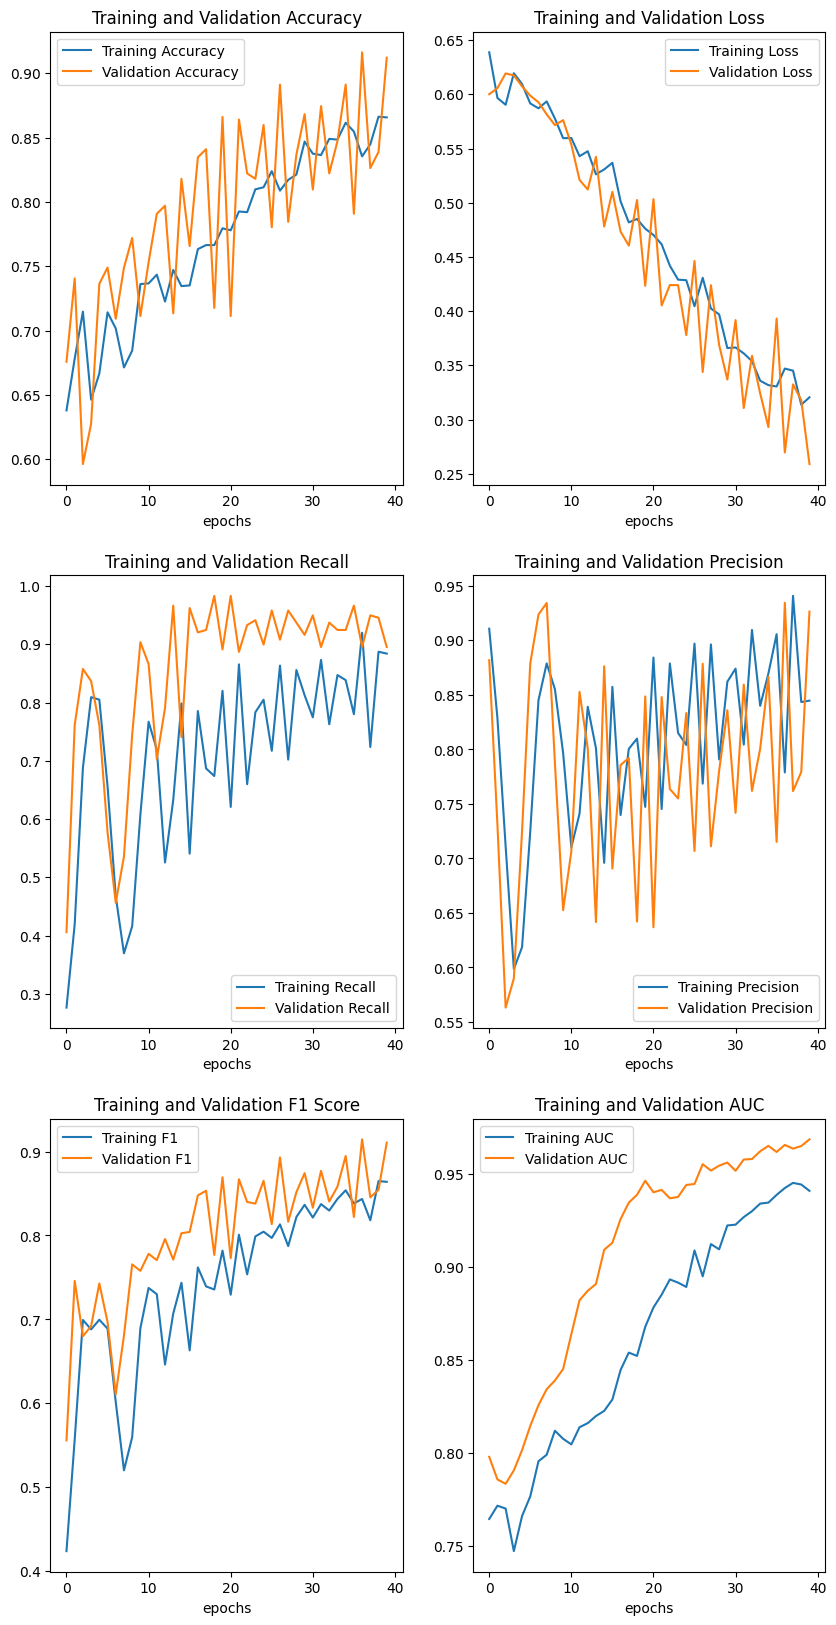

In [39]:

# Display the plots showing the metrics vs epochs
f1=history.history['f1']
val_f1= history.history['val_f1']
loss=history.history['loss']
val_loss= history.history['val_loss']
recall=history.history['recall']
val_recall= history.history['val_recall']
precision=history.history['precision']
val_precision= history.history['val_precision']
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
auc=history.history['auc']
val_auc=history.history['val_auc']

epoch = range(len(f1))
plt.figure(figsize=(10,20))

plt.subplot(3,2,1)
plt.plot(epoch,acc,label='Training Accuracy')
plt.plot(epoch,val_acc,label='Validation Accuracy')
plt.xlabel("epochs")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(3,2,2)
plt.plot(epoch,loss,label='Training Loss')
plt.plot(epoch,val_loss,label='Validation Loss')
plt.xlabel("epochs")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(3,2,3)
plt.plot(epoch,recall,label='Training Recall')
plt.plot(epoch,val_recall,label='Validation Recall')
plt.xlabel("epochs")
plt.legend()
plt.title("Training and Validation Recall")

plt.subplot(3,2,4)
plt.plot(epoch,precision,label='Training Precision')
plt.plot(epoch,val_precision,label='Validation Precision')
plt.xlabel("epochs")
plt.legend()
plt.title("Training and Validation Precision")

plt.subplot(3,2,5)
plt.plot(epoch,f1,label='Training F1')
plt.plot(epoch,val_f1,label='Validation F1')
plt.xlabel("epochs")
plt.legend()
plt.title("Training and Validation F1 Score")

plt.subplot(3,2,6)
plt.plot(epoch,auc,label='Training AUC')
plt.plot(epoch,val_auc,label='Validation AUC')
plt.xlabel("epochs")
plt.legend()
plt.title("Training and Validation AUC")

#### Training Metrics evaluation

In [40]:
train_images, train_labels = next(iter(train_ds))
model.evaluate(train_images, train_labels)
train_pred = model.predict(train_images)


60/60 [==============================] - 3s 55ms/step


[[887 104]
 [ 94 829]]
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90       991
         1.0       0.89      0.90      0.89       923

    accuracy                           0.90      1914
   macro avg       0.90      0.90      0.90      1914
weighted avg       0.90      0.90      0.90      1914

ROC Score 0.8966068396718899


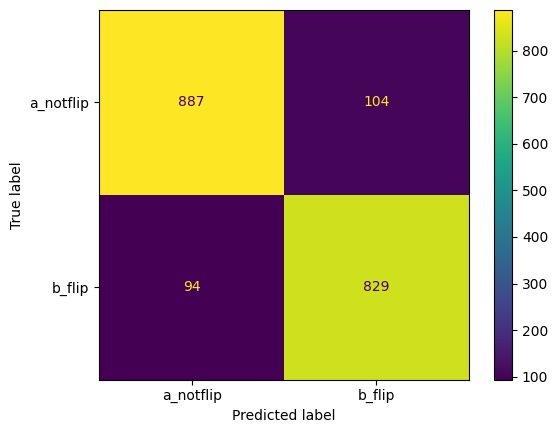

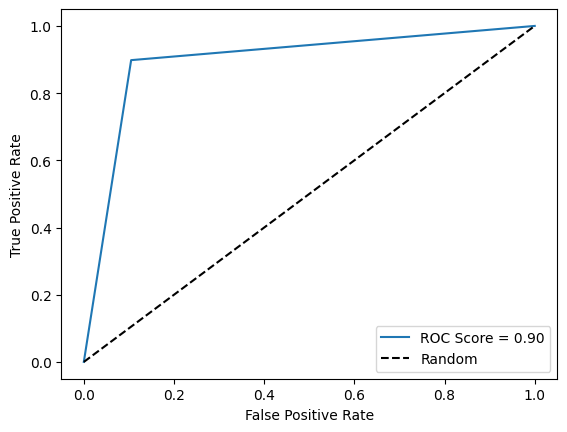

In [41]:
cm_train = confusion_matrix(train_labels, np.round(train_pred))
print(cm_train)
from sklearn.metrics import classification_report
print(classification_report(train_labels,np.round(train_pred)))
cm_train_plot=ConfusionMatrixDisplay(cm_train,display_labels=class_names)
cm_train_plot.plot()

from sklearn.metrics import roc_auc_score,roc_curve
roc_auc=roc_auc_score(train_labels,np.round(train_pred))
print("ROC Score",roc_auc)
fpr,tpr,threshold = roc_curve(train_labels,np.round(train_pred))
plt.figure()
plt.plot(fpr,tpr,label='ROC Score = %0.2f' % roc_auc)
plt.plot((0,1),(0,1),"--",color='black',label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [42]:
# train_label = np.concatenate([y for x,_ in train_ds], axis=0)
# train_images = np.concatenate([x for _,y in train_ds], axis=1)

# train_images = [x for x,_ in train_ds]
# train_labels = [y for _,y in  train_ds]
# train_images = np.concatenate(train_images , axis = 0)
# train_labels = np.concatenate(train_labels , axis = 0)

# while j <=60:
# for images, labels in train_ds.take(2):
#     np.append(train_images,images[i].numpy())
#     np.append(train_labels,labels[i])
#     # j=j+1



In [ ]:
# train_images = []
# for x, y in train_ds:
#     train_images.append(y)

# # Check that all arrays have the same shape along dimension 0
# shape = train_images[0].shape[0]
# for i in range(1, len(train_images)):
#     if train_images[i].shape[0] != shape:
#         raise ValueError("All arrays in train_images must have the same shape along dimension 0.")

# # Concatenate the arrays along axis 1
# train_images = np.concatenate(train_images, axis=1)

In [ ]:
# y_pred = (model.predict(train_ds) > 0.5).astype("int32")
# model.evaluate(train_images, train_labels)
# y_prob = model.predict(train_ds)
# y_pred = (y_prob > 0.5).astype("int32")

In [ ]:
# for image_batch, labels_batch in train_ds:
# iterator = iter(train_ds)
# for image_batch, labels_batch in train_ds:
#      iterator.get_next()
#      np.append(train_images,iterator.get_next())
#      np.append(train_labels,labels_batch.numpy())
#      break
# train_labels=[]
# i=1
# while i<=60:
#     train_images, train_labels = next(iter(train_ds))
#     train_images=np.concatenate
#     i=i=1
# train_labels



In [43]:


# model.evaluate(train_images, train_labels)
# train_pred = model.predict(train_images)
# cm_train = confusion_matrix(train_labels, np.round(train_pred))
# print(cm_train)
# from sklearn.metrics import classification_report
# print(classification_report(train_labels,np.round(train_pred)))
# cm_train_plot=ConfusionMatrixDisplay(cm_train,display_labels=class_names)
# cm_train_plot.plot()

# from sklearn.metrics import roc_auc_score,roc_curve
# roc_auc=roc_auc_score(train_labels,np.round(train_pred))
# print("ROC Score",roc_auc)
# fpr,tpr,threshold = roc_curve(train_labels,np.round(train_pred))
# plt.figure()
# plt.plot(fpr,tpr,label='ROC Score = %0.2f' % roc_auc)
# plt.plot((0,1),(0,1),"--",color='black',label="Random")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend()
# plt.show()

In [44]:
# train_label[:10]

In [45]:
# y_pred[:10]

In [46]:
# from sklearn.metrics import classification_report
# print(classification_report(train_label,y_pred))

In [47]:
# cm=confusion_matrix(train_label,y_pred)

In [48]:
# cm_plot=ConfusionMatrixDisplay(cm,display_labels=class_names)
# cm_plot.plot()

In [49]:
# # train_pred = (model.predict(train_ds))
# from sklearn.metrics import roc_auc_score,roc_curve
# roc_auc=roc_auc_score(train_label,y_prob)
# print("ROC Score",roc_auc)
# fpr,tpr,threshold = roc_curve(train_label,y_prob)
# plt.figure()
# plt.plot(fpr,tpr,label='ROC Score = %0.2f' % roc_auc)
# plt.plot((0,1),(0,1),"--",color='black',label="Random")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend()
# plt.show()

#### Test the model on the test data and display the confusion matrix

Rename the test directory and read the images from the test directory

In [53]:
! mv images/testing/notflip images/testing/a_notflip
! mv images/testing/flip images/testing/b_flip

In [54]:
test_path ="images/testing"
test_path
test_ds=image_dataset_from_directory(test_path,labels="inferred",label_mode='binary',shuffle=True,image_size=(img_height,img_width),batch_size=597)

Found 597 files belonging to 2 classes.


#### Confusion Matrix for Test Data



In [51]:
# test_label = np.concatenate([y for x, y in test_ds], axis=0)
# # y_testpred = model.predict(test_ds)
# # y_testpred = np.argmax(y_testpred).astype(int)
# y_testprob= model.predict(test_ds)
# y_testpred= (y_testprob > 0.5).astype("int32")
# cm=confusion_matrix(test_label,y_testpred)
# cm_plot=ConfusionMatrixDisplay(cm,display_labels=class_names)
# cm_plot.plot()

In [52]:
# from sklearn.metrics import roc_auc_score,roc_curve
# roc_auc=roc_auc_score(test_label,y_testprob)
# print("ROC Score",roc_auc)
# fpr,tpr,threshold = roc_curve(test_label,y_testprob)
# plt.figure()
# plt.plot(fpr,tpr,label='ROC Score = %0.2f' % roc_auc)
# plt.plot((0,1),(0,1),"--",color='black',label="Random")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend()
# plt.show()

#### Predict on Single iteration of Test image dataset

In [55]:
test_images, test_labels = next(iter(test_ds))
model.evaluate(test_images, test_labels)
pred = model.predict(test_images)
from sklearn.metrics import classification_report
print(classification_report(test_labels,np.round(pred)))

19/19 [==============================] - 1s 52ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       307
         1.0       0.89      0.85      0.87       290

    accuracy                           0.88       597
   macro avg       0.88      0.88      0.88       597
weighted avg       0.88      0.88      0.88       597



In [56]:
cm_test = confusion_matrix(test_labels, np.round(pred))
print(cm_test)
from sklearn.metrics import classification_report
print(classification_report(test_labels,np.round(pred)))

[[277  30]
 [ 44 246]]
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       307
         1.0       0.89      0.85      0.87       290

    accuracy                           0.88       597
   macro avg       0.88      0.88      0.88       597
weighted avg       0.88      0.88      0.88       597



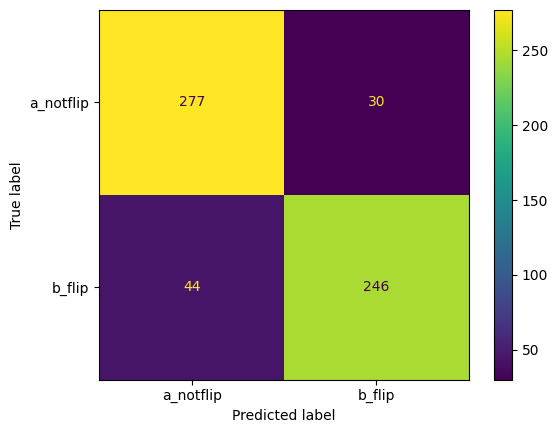

In [57]:
cm_test_plot=ConfusionMatrixDisplay(cm_test,display_labels=class_names)
cm_test_plot.plot()

ROC Score 0.8752779961810626


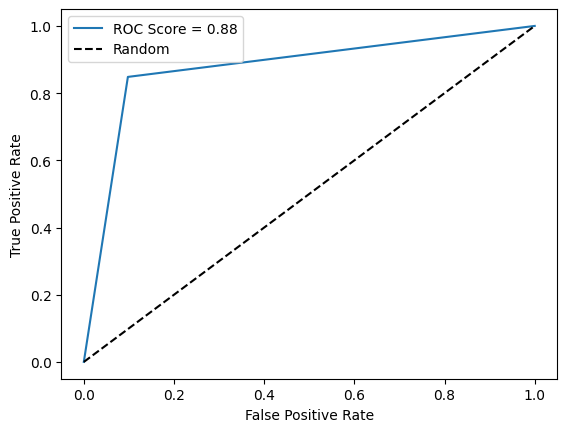

In [58]:
from sklearn.metrics import roc_auc_score,roc_curve
roc_auc=roc_auc_score(test_labels,np.round(pred))
print("ROC Score",roc_auc)
fpr,tpr,threshold = roc_curve(test_labels,np.round(pred))
plt.figure()
plt.plot(fpr,tpr,label='ROC Score = %0.2f' % roc_auc)
plt.plot((0,1),(0,1),"--",color='black',label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### Model testing using random images from the test data set

Testing the model for images from b_flip

Test image path images/testing/b_flip/0007_000000024.jpg
Test image 



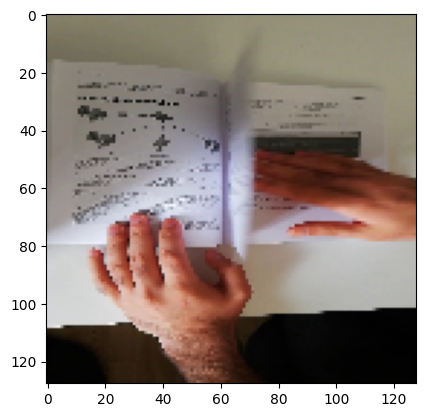

1/1 [==============================] - 0s 32ms/step
Model Prediction: Image is Flipped

Test image path images/testing/b_flip/0018_000000004.jpg
Test image 



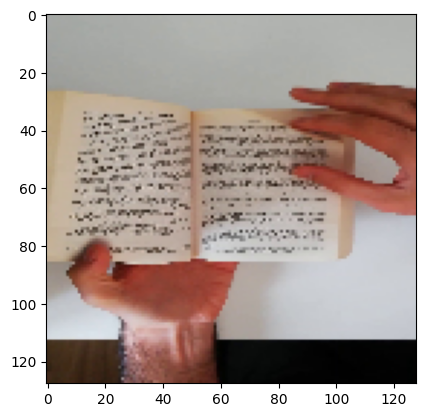

1/1 [==============================] - 0s 31ms/step
Model Prediction: Image is Flipped

Test image path images/testing/b_flip/0006_000000024.jpg
Test image 



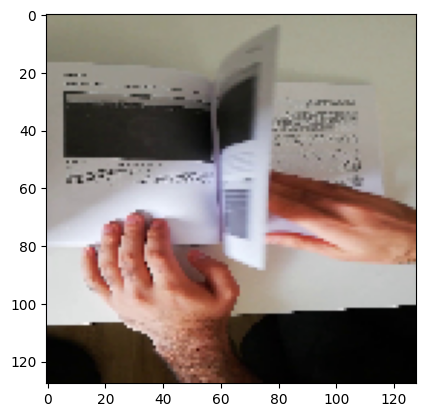

1/1 [==============================] - 0s 30ms/step
Model Prediction: Image is Flipped

Test image path images/testing/b_flip/0017_000000015.jpg
Test image 



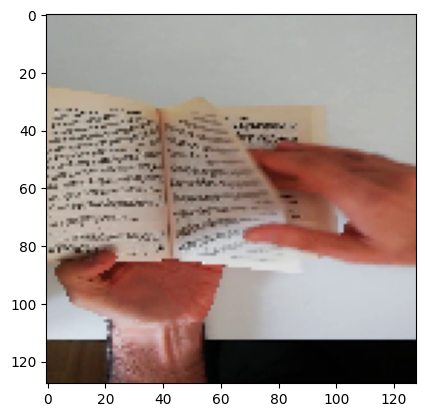

1/1 [==============================] - 0s 32ms/step
Model Prediction: Image is Flipped

Test image path images/testing/b_flip/0040_000000024.jpg
Test image 



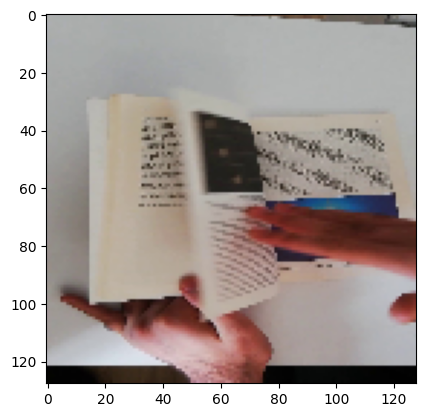

1/1 [==============================] - 0s 31ms/step
Model Prediction: Image is Flipped



In [59]:
import numpy as np
def test_model(test):
  testdir='images/testing/'+ test
  dirlist=os.listdir(testdir)
  print("Testing the model for images from " + test )
  print("")
  for i in range(5):
    print("Test image path",os.path.join(testdir,dirlist[i]))
    print("Test image ")
    print("")
    fname = testdir + '/'+ dirlist[i]
    im=tf.keras.utils.load_img(fname, target_size=(128,128))
    plt.imshow(im)
    plt.show()
    img=tf.keras.utils.img_to_array(im)
    img=img/255
    testimg = np.expand_dims(img, axis=0)
    pred=model.predict(testimg,batch_size=10)
    predictions = tf.where(pred[0] < 0.5,0, 1)
    if predictions == 0:
        print("Model Prediction: Image is Not Flipped")
        print("")
    elif predictions == 1:
        print("Model Prediction: Image is Flipped")
        print("")

test_model('b_flip')


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
model.save('/content/gdrive/MyDrive/monreader.keras')
!ls


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
drive  gdrive  images  sample_data


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)
